In [7]:
import numpy as np
import pickle
from numpy import *
import threading
from PIL import Image as pil_image
import random
import plotly.express as px

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import pandas as pd
# import tensorflow_datasets as tfds

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
trainpath = r"C:\Users\evo\Desktop\Datasets\Covid19-dataset\train"
testpath = r".../test"
valpath = r"C:\Users\evo\Desktop\Datasets\Covid19-dataset\test"

In [11]:
def getClassNames(path):
  dir_path = path
  class_names = []

  # Loop through all the files in the directory
  for file_name in os.listdir(dir_path):
      # Check if the file is a directory
      if os.path.isdir(os.path.join(dir_path, file_name)):
          # Extract the name of the directory and append it to the list
          class_names.append(file_name)
          
  class_names = sorted(class_names)

  print("Class Names:\t", class_names)
  return class_names  

In [ ]:
IMG_SIZE = 200
imageShape = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 16
CATEGORIES = getClassNames(trainpath)
output_number = len(CATEGORIES)

In [ ]:
def load_image(addr):
    image = pil_image.open(addr)
    image = np.asarray(image.resize((IMG_SIZE, IMG_SIZE), pil_image.ANTIALIAS), dtype=np.float32)
    return image

In [ ]:
class_names = sorted(os.listdir(trainpath))
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [ ]:
class_dis = [len(os.listdir(trainpath + '\\' + name)) for name in class_names]
class_dis

[111, 70, 70]

In [ ]:
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

In [ ]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

In [ ]:
train_ds = train_gen.flow_from_directory(trainpath,target_size=imageShape,batch_size=BATCH_SIZE, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(valpath,target_size=imageShape,batch_size=BATCH_SIZE, subset='validation', class_mode='categorical')

Found 201 images belonging to 3 classes.
Found 13 images belonging to 3 classes.


In [ ]:
class_names = sorted(os.listdir(trainpath))
class_names

['Covid', 'Normal', 'Viral Pneumonia']

In [ ]:
def plot_images(data, class_names):
    
    r, c = 3, 4
    imgLen = r*c
    
    plt.figure(figsize=(20, 15))
    i = 1
    
    for images, labels in iter(data):
        
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        
        i+=1
        if i > imgLen:
            break
    plt.show()

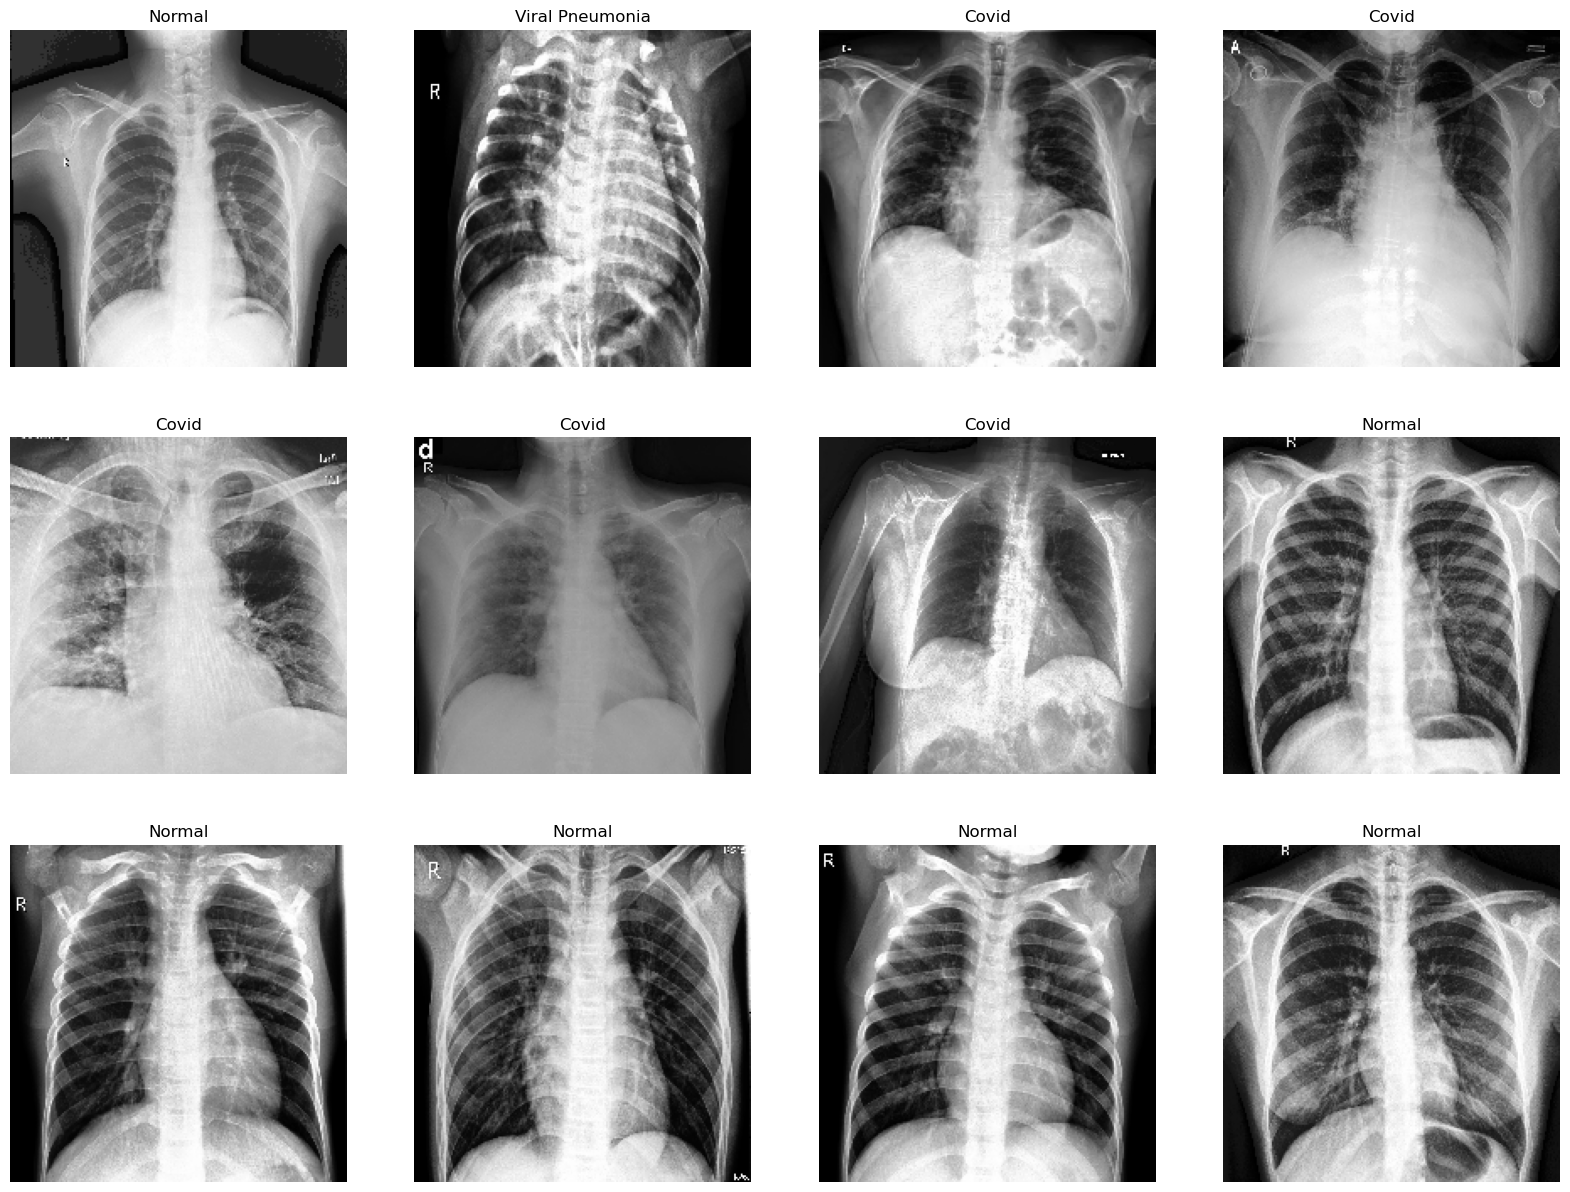

In [ ]:
plot_images(train_ds, class_names)

In [ ]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(output_number, activation='softmax')
])

In [ ]:
model.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 36864)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4718720   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [ ]:
print("Random Ratio: ", 1/output_number)

early_stop = EarlyStopping(monitor='accuracy', patience=7)

# Training
history = model.fit(
            train_ds,
            epochs=50,
            validation_data=val_ds,
            verbose=1,
            callbacks=[early_stop])

Random Ratio:  0.3333333333333333
Epoch 1/50
13/13 [==============================] - 5s 216ms/step - loss: 1.0711 - accuracy: 0.4229 - val_loss: 1.0065 - val_accuracy: 0.4615
Epoch 2/50
13/13 [==============================] - 3s 231ms/step - loss: 0.9866 - accuracy: 0.5473 - val_loss: 0.7993 - val_accuracy: 0.8462
Epoch 3/50
13/13 [==============================] - 3s 226ms/step - loss: 0.7463 - accuracy: 0.6816 - val_loss: 0.5953 - val_accuracy: 0.6923
Epoch 4/50
13/13 [==============================] - 3s 220ms/step - loss: 0.5833 - accuracy: 0.7612 - val_loss: 0.6750 - val_accuracy: 0.6154
Epoch 5/50
13/13 [==============================] - 3s 227ms/step - loss: 0.5433 - accuracy: 0.7711 - val_loss: 0.4465 - val_accuracy: 0.7692
Epoch 6/50
13/13 [==============================] - 3s 230ms/step - loss: 0.4515 - accuracy: 0.8010 - val_loss: 0.2775 - val_accuracy: 0.9231
Epoch 7/50
13/13 [==============================] - 3s 226ms/step - loss: 0.4881 - accuracy: 0.7612 - val_loss: 0.

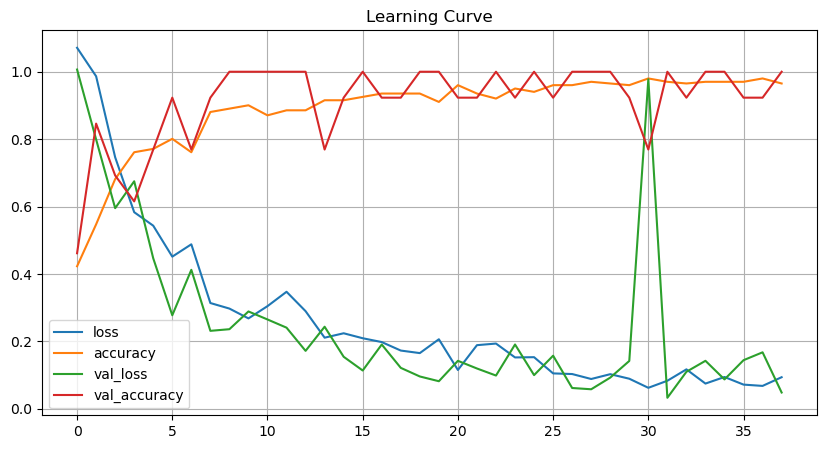

In [ ]:
learningcurve = pd.DataFrame(history.history)
learningcurve.plot(figsize=(10, 5))
plt.title("Learning Curve")
plt.grid()